# Damköhler numbers

In [ ]:
import numpy as np
from lucifex.solver import OptionsPETSc
from lucifex.fdm import AB, CN
from lucifex.sim import run, Simulation
from lucifex.viz import plot_colormap, plot_line
from crocodil.dns import dns_system_a, SYSTEM_A_REFERENCE

STORE = 1
NX = 100
NY = 100

def create_simulation(
    Da: float,
):
    physical = dict(SYSTEM_A_REFERENCE)
    physical.update(Da=Da)
    return dns_system_a(
        store_delta=STORE, 
    )(
        Nx=NX,
        Ny=NY,
        scaling='advective',
        **physical,
        D_adv=AB(1)@CN,
        D_diff=AB(1)@CN,
        dt_max=0.1,
        cfl_courant=0.5,
        c_stabilization=None,
        c_limits=None,
        c_petsc=OptionsPETSc('gmres', 'ilu'),
        flow_petsc=(OptionsPETSc('cg', 'hypre'), None),
        diagnostic=True,
    )


Da_opts = (10.0, 100.0, 1000.0)
simulations: dict[float, Simulation] = {}

for Da in Da_opts:
    simulations[Da] = create_simulation(Da)


n_stop = 500
t_stop = 20.0
dt_init = 1e-6
n_init = 10
for Da in Da_opts:
    sim = simulations[Da]
    run(sim, n_stop, t_stop, dt_init=dt_init, n_init=n_init)

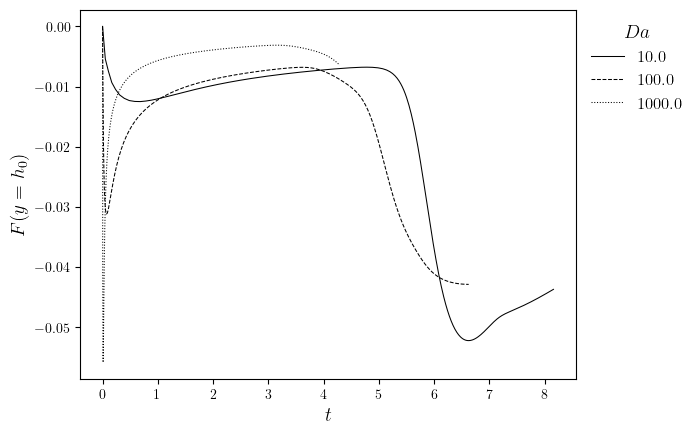

In [2]:
lines = []
for Da in Da_opts:
    sim = simulations[Da]
    f = sim['f']
    f, fPlus, fMinus = f.split()
    lines.append((f.time_series, [np.sum(i) for i in f.value_series]))

fig, ax = plot_line(
    lines,
    cyc='black',
    x_label='$t$',
    y_label='$F(y=h_0)$',
    legend_labels=list(Da_opts),
    legend_title='$Da$',
)


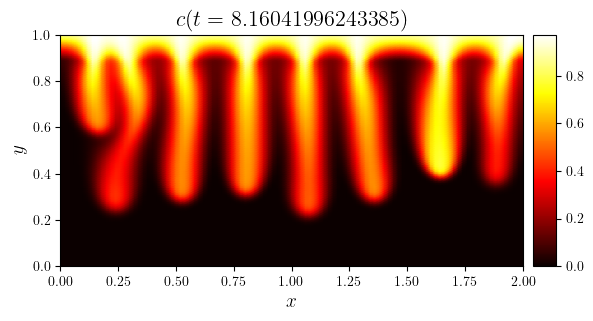

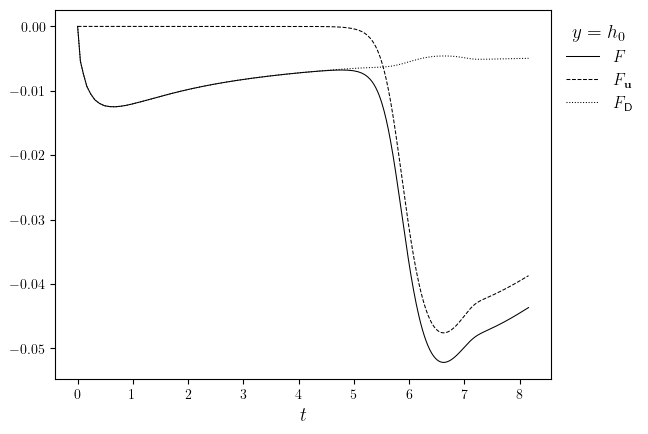

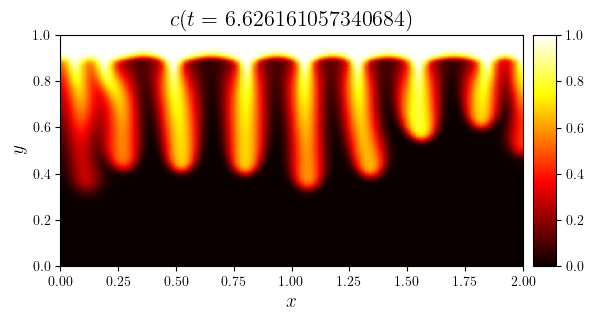

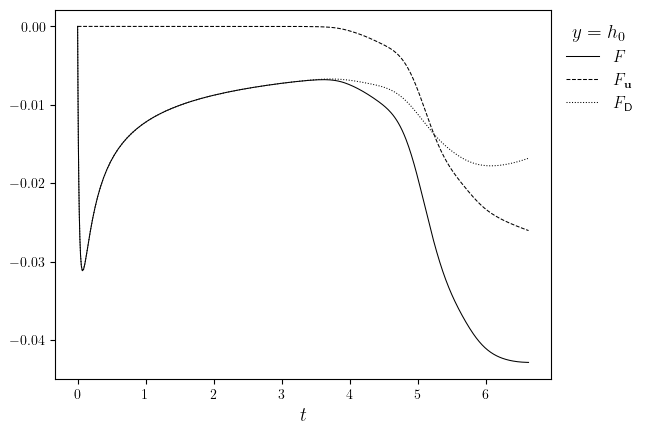

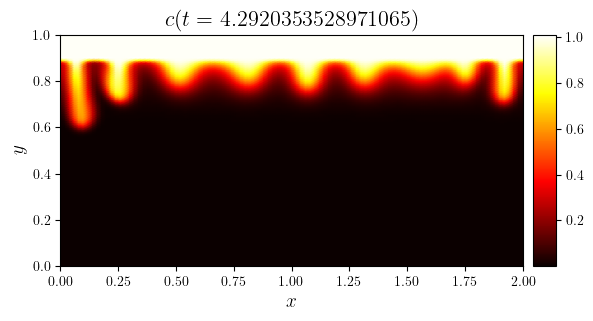

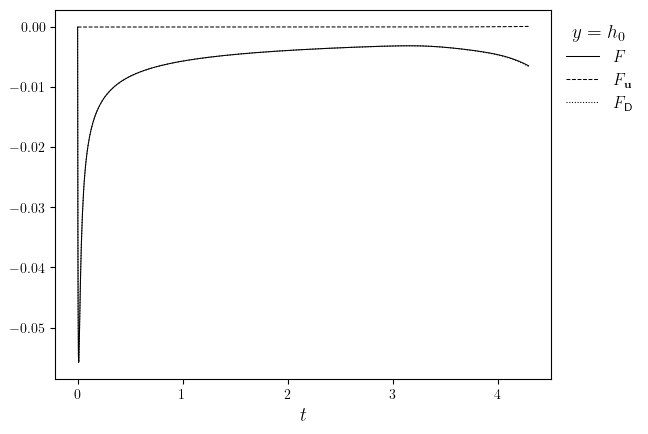

In [ ]:
time_index = -1
for Da in Da_opts:
    sim = simulations[Da]
    c = sim['c']
    fig, ax = plot_colormap(
        c.series[time_index], 
        title=f'$Da={Da}$\n$c(t={c.time_series[time_index]})$',
    )
    f = sim['f']
    f, fPlus, fMinus = f.split()
    fig, ax = plot_line(
    [(f.time_series, [np.sum(i) for i in f.value_series]), (f.time_series, f.value_series)],
    cyc='black',
    x_label='$t$',
    legend_labels=['$F$', '$F_{\mathbf{u}}$', '$F_{\mathsf{D}}$'],
    legend_title='$Da={Da}$\n$y=h_0$',
)